In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

MIN_MATCH_COUNT = 10

main_path = "../../"
img1 = cv.imread(f"{main_path}homography/experiments/_map_empty.jpg", cv.IMREAD_GRAYSCALE)       # queryImage
img2 = cv.imread(f"{main_path}homography/experiments/maps.png", cv.IMREAD_GRAYSCALE)       # trainImage

In [2]:
# Initiate SIFT detector
sift = cv.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)

flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1,des2,k=2)

# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

In [3]:
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0)
    matchesMask = mask.ravel().tolist()
    h,w = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv.perspectiveTransform(pts,M)
    img2 = cv.polylines(img2,[np.int32(dst)],True,255,3, cv.LINE_AA)
    print(M)
else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None

[[-4.70301566e-01 -2.08377382e+01  1.08392851e+03]
 [ 1.94428464e-03 -1.17827427e+01  5.18569163e+02]
 [-3.99532983e-04 -1.93218860e-02  1.00000000e+00]]


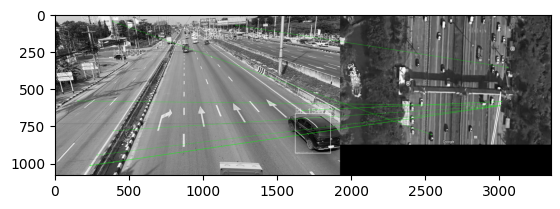

(<matplotlib.image.AxesImage at 0x253d32ee310>, None)

In [4]:
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)

img3 = cv.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)

plt.imshow(img3, 'gray'),plt.show()